# Chapter 3 - Recovery via convex programs

This notebook reproduces some of the figures in Chapter 3 of the thesis.

## Preamble

*Important*: Make sure to replace the string in the cell below with the path to your local copy of the GSSR repository.

In [1]:
cmd_folder = '../../gssr' # Insert here the string pointing to the gssr root folder

# Make sure the gssr folder is in the python path
import os, sys
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# Import the needed gssr modules
import utils
import plotting
    
import graphs_signals as gs
import sampling as smp
import recovery as rec

Now we can import the rest of the Python modules needed for this notebook.

In [2]:
import pygsp
pygsp.plotting.BACKEND = 'matplotlib'

import numpy as np
np.random.seed(42) # For reproducibility

import matplotlib.pyplot as plt
plt.style.use('thesis.mplstyle')
%matplotlib inline

import helper
helper.set_pgf_preamble()

The next cell sets the path to the Swiss National Council data, the path to the save folder, and a custom matplotlib colormap.

In [3]:
data_path = os.path.join(cmd_folder, 'data/swiss-national-council')
save_path = '../latex/images/'
helper.set_cmap('signal')

## Load the data

The Swiss National Council graph is loaded from a GSSR function. We then save the party colors as a graph signal.

In [4]:
nn_params = {'NNtype': 'knn',
             'use_flann': True,
             'center': False,
             'rescale': True,
             'k': 25,
             'dist_type': 'euclidean'}
graph, indicator_vectors = gs.swiss_national_council(path=data_path, **nn_params)
party_colors = graph.info['councillors']['PartyColor']

## A party indicator vector vs. the rows of $\mathbf{D}^{+}$ 

Let us re-use the `swiss-national-council` data and take the indicator vector of the [UDC](https://www.udc.ch/parti/) party as graph signal.

In [27]:
parties = graph.info['parties']
parties_in_gt = ['UDC']
cls_mask = [False] * len(parties)
for p in parties_in_gt:
    cls_mask += (parties == p)

signal = np.sum(indicator_vectors[cls_mask,:], axis=0)

Now, we compute the Moore-Penrose pseudo-inverse of the graph gradient and pick among its columns the one that is best "aligned" with the indicator vector above.

In [70]:
D_plus = np.linalg.pinv(graph.D.T.toarray())

atom_norms = np.linalg.norm(D_plus.T, axis=1)

alignment_factors = (D_plus.T @ signal) / atom_norms

idx = np.argmax(np.abs(alignment_factors))

best_atom = np.reshape(D_plus[:, idx], (len(signal), ))

The next cell shows a side-by-side comparison of those two signals

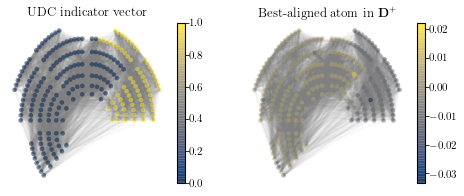

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7.88, 2.94))

plotting.plot_graph(graph, 
                    signal, 
                    ax=ax[0], 
                    limits = [min(signal), max(signal)], 
                    edges=True, 
                    colorbar=True)

plotting.plot_graph(graph, 
                    best_atom, 
                    limits = [min(best_atom), max(best_atom)],
                    ax=ax[1], 
                    edges=True, 
                    colorbar=True)

ax[0].set(title='UDC indicator vector')
ax[1].set(title=r'Best-aligned atom in $\mathbf{D}^{+}$')

plt.savefig(os.path.join(save_path, 'snc_udc_indicator_and_closest_pinv_atom.pdf'))
plt.show()